## 📝 Note

This notebook demonstrates the training process interactively. For production use or automated training, consider using the modular Python scripts in the `scripts/` directory:

- `scripts/train.py` - Complete training pipeline
- `scripts/evaluate.py` - Model evaluation
- `scripts/predict.py` - Single image inference

The core functionality has been organized into modules in the `src/` directory for better code organization and reusability.

# Belgian Bird Species Classifier

This notebook implements a high-accuracy image classifier for Belgian bird species using PyTorch and transfer learning with EfficientNet. The model is trained on a custom dataset containing approximately 130 images per species, with each image resized to 224×224.

## 1. Setup and Dependencies

First, we'll import all necessary libraries and set random seeds for reproducibility.

In [16]:
# Install required packages if needed
import sys
import subprocess

# Check if running in Colab (skip if running locally)
try:
    assert EOFError
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab, installing required packages...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "timm", "albumentations", "huggingface_hub"])
except:
    IN_COLAB = False
    # Install huggingface_hub if not available
    try:
        import huggingface_hub
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "huggingface_hub"])

# Import dependencies
import os
import random
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image

# Safe import of tqdm with fallback
try:
    from tqdm.notebook import tqdm
    # Test if it actually works
    tqdm(range(1))
except (ImportError, ModuleNotFoundError):
    print("tqdm.notebook not available, falling back to regular tqdm")
    from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
import torchvision.transforms as transforms
from torchvision.transforms import v2 as transforms_v2
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Exception ignored in: <function tqdm.__del__ at 0x7ff7a3486840>
Traceback (most recent call last):
  File "/home/ezclap/aizen/313BIRDS/lib/python3.13/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/home/ezclap/aizen/313BIRDS/lib/python3.13/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


tqdm.notebook not available, falling back to regular tqdm
Using device: cuda


## 2. Dataset Configuration

Define dataset paths and configuration parameters.

In [40]:
# Dataset download and configuration
from huggingface_hub import snapshot_download
from pathlib import Path

# Download dataset from Hugging Face
print("Downloading dataset from Hugging Face...")
LOCAL_DIR = "../data/BelgianSpecies"
snapshot_download(
    repo_id="Ez-Clap/bird-species",
    repo_type="dataset",
    local_dir=LOCAL_DIR,
    local_dir_use_symlinks=False,
    allow_patterns=["BelgianSpecies/train/**", "BelgianSpecies/test/**", "BelgianSpecies/valid/**", "BelgianSpecies/validation/**", "BelgianSpecies/val/**"],
    revision="main"
)

# Dataset paths
DATA_ROOT = Path(LOCAL_DIR)
TRAIN_DIR = DATA_ROOT / 'train'
TEST_DIR = DATA_ROOT / 'test'
VALID_DIR = DATA_ROOT / 'valid'

# Check which validation directory exists
if not VALID_DIR.exists():
    if (DATA_ROOT / 'validation').exists():
        VALID_DIR = DATA_ROOT / 'validation'
    elif (DATA_ROOT / 'val').exists():
        VALID_DIR = DATA_ROOT / 'val'

print(f"Dataset downloaded to: {DATA_ROOT}")
print(f"Train directory: {TRAIN_DIR}")
print(f"Test directory: {TEST_DIR}")
print(f"Valid directory: {VALID_DIR}")

# Configuration parameters
BATCH_SIZE = 32
NUM_WORKERS = 4
IMG_SIZE = 224
NUM_EPOCHS_PHASE1 = 10
NUM_EPOCHS_PHASE2 = 30
LEARNING_RATE_PHASE1 = 1e-3
LEARNING_RATE_PHASE2 = 2e-4
LABEL_SMOOTHING = 0.1
WEIGHT_DECAY = 1e-4

# Get class names and number of classes
class_names = sorted([d.name for d in TRAIN_DIR.iterdir() if d.is_dir()])
NUM_CLASSES = len(class_names)
print(f"Found {NUM_CLASSES} classes: {class_names}")

/home/ezclap/aizen/313BIRDS/lib/python3.13/site-packages/huggingface_hub/file_download.py:982: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(
Fetching 7205 files:   2%|▏         | 132/7205 [01:15<1:07:25,  1.75it/s]


KeyboardInterrupt: 

## 3. Custom Dataset and Data Augmentation

We'll create a custom dataset class to load images from disk and apply different augmentations to train and validation sets:

- **Training augmentations**: 
  - Horizontal flips
  - Random rotations (±15°)
  - Random resized crops
  - Color jitter (brightness, contrast, saturation)
  - Random erasing
  
- **Validation/Test augmentations**:
  - Center crop/resize
  - Normalization with ImageNet mean and std

Using strong augmentation helps improve generalization on small datasets.

In [18]:
# ImageNet mean and std for normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Define augmentations using albumentations for more efficient and comprehensive transforms
train_transform = A.Compose([
    A.RandomResizedCrop(size=(IMG_SIZE, IMG_SIZE), scale=(0.7, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    A.CoarseDropout(max_holes=1, max_height=32, max_width=32, p=0.2),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE + 32, IMG_SIZE + 32),
    A.CenterCrop(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2(),
])

# Custom Dataset class
class BirdSpeciesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}
        
        # Load all image paths and labels
        for class_folder in sorted(self.root_dir.iterdir()):
            if class_folder.is_dir():
                class_idx = self.class_to_idx[class_folder.name]
                for img_path in class_folder.glob('*.jpg'):
                    self.image_paths.append(img_path)
                    self.labels.append(class_idx)
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = np.array(Image.open(img_path).convert('RGB'))
        label = self.labels[idx]
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
            
        return image, label
    
# Create datasets
train_dataset = BirdSpeciesDataset(TRAIN_DIR, transform=train_transform)
valid_dataset = BirdSpeciesDataset(VALID_DIR, transform=val_transform)
test_dataset = BirdSpeciesDataset(TEST_DIR, transform=val_transform)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 6775
Validation dataset size: 215
Test dataset size: 215


/tmp/ipykernel_10516/1221990195.py:12: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=1, max_height=32, max_width=32, p=0.2),


### Visualize Sample Images with Augmentations

Let's visualize some samples from our dataset with the applied augmentations to make sure everything is working correctly.

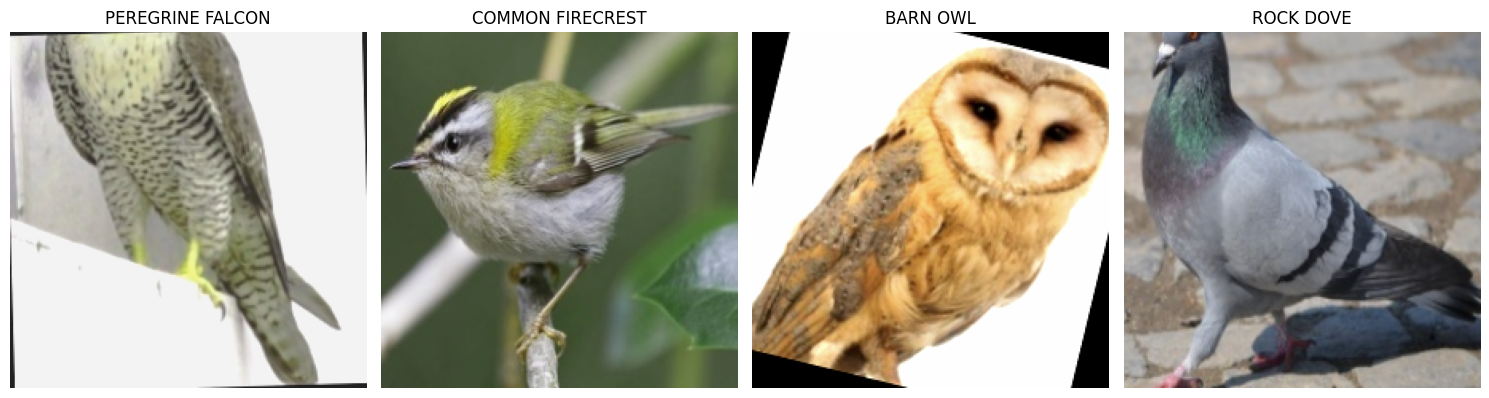

In [19]:
# Function to show images
def show_samples(dataset, num_samples=4, cols=4):
    figure = plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        image, label = dataset[random.randint(0, len(dataset)-1)]
        
        if isinstance(image, torch.Tensor):
            # Convert tensor to numpy array for display
            image = image.numpy().transpose(1, 2, 0)
            # Unnormalize the image
            image = image * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)
            # Clip values to valid range
            image = np.clip(image, 0, 1)
        
        plt.subplot(1, cols, i+1)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show sample training images with augmentation
show_samples(train_dataset)

## 4. Data Loaders and Cross-Validation Setup

We'll implement K-Fold cross-validation to make the most of our small dataset. 
This ensures all data is used for both training and validation at different times.

In [20]:
from sklearn.model_selection import KFold

# DataLoader function for training and validation splits
def get_data_loaders(train_dataset, valid_dataset=None, test_dataset=None, 
                    batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,
                    k_fold=5, fold_index=0):
    
    if valid_dataset is not None:
        # If validation set is provided, use standard train/val/test split
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            pin_memory=True
        )
        
        valid_loader = DataLoader(
            valid_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=True
        )
        
        test_loader = None
        if test_dataset:
            test_loader = DataLoader(
                test_dataset,
                batch_size=batch_size,
                shuffle=False,
                num_workers=num_workers,
                pin_memory=True
            )
        
        return train_loader, valid_loader, test_loader, None
    
    else:
        # If no validation set, use K-fold cross-validation
        indices = list(range(len(train_dataset)))
        kfold = KFold(n_splits=k_fold, shuffle=True, random_state=SEED)
        
        # Get train/val indices for the current fold
        train_folds = []
        val_folds = []
        
        for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(indices)):
            train_folds.append(train_idx)
            val_folds.append(val_idx)
        
        # Use the specified fold
        train_idx = train_folds[fold_index]
        val_idx = val_folds[fold_index]
        
        # Create samplers
        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)
        
        # Create data loaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            sampler=train_sampler,
            num_workers=num_workers,
            pin_memory=True
        )
        
        valid_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            sampler=val_sampler,
            num_workers=num_workers,
            pin_memory=True
        )
        
        # Return fold information for potential ensemble later
        return train_loader, valid_loader, None, (train_folds, val_folds)

# Define k-fold cross-validation parameters
K_FOLDS = 5
CURRENT_FOLD = 0  # Start with the first fold

# Get dataloaders
train_loader, val_loader, test_loader, fold_info = get_data_loaders(
    train_dataset, valid_dataset, test_dataset, 
    k_fold=K_FOLDS, fold_index=CURRENT_FOLD
)

print(f"Number of batches in train loader: {len(train_loader)}")
print(f"Number of batches in validation loader: {len(val_loader)}")
if test_loader:
    print(f"Number of batches in test loader: {len(test_loader)}")

Number of batches in train loader: 212
Number of batches in validation loader: 7
Number of batches in test loader: 7


## 5. Model Architecture

We'll use EfficientNet-B3 from the `timm` library with pre-trained weights from ImageNet. The classifier head will be replaced with a new linear layer matching our number of bird species.

In [21]:
def create_model(num_classes, model_name="efficientnet_b3", pretrained=True):
    # Create a model with pretrained weights
    model = timm.create_model(model_name, pretrained=pretrained)
    
    # Replace classifier head
    if 'efficientnet' in model_name:
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, num_classes)
    else:
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
    
    return model

# Create model and move to device
model = create_model(NUM_CLASSES)
model = model.to(device)

# Print model summary
print(model)
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

EfficientNet(
  (conv_stem): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
        (bn1): BatchNormAct2d(
          40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (b

## 6. Training Functions

Now we'll define training and validation functions, including:
- Loss function with label smoothing (which helps prevent overfitting)
- Optimizers (AdamW for better weight decay handling)
- Learning rate schedulers
- Early stopping
- Model checkpoint saving

In [22]:
# Define loss function with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

# Training function
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Use tqdm for progress tracking with a simple fallback mechanism
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc="Training")
    for batch_idx, (inputs, targets) in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        # Calculate statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f"{running_loss / (batch_idx + 1):.4f}",
            'acc': f"{100. * correct / total:.2f}%"
        })
    
    return running_loss / len(dataloader), 100. * correct / total

# Validation function
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc="Validation")
        for batch_idx, (inputs, targets) in progress_bar:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Calculate statistics
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Store predictions and targets for later analysis
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': f"{running_loss / (batch_idx + 1):.4f}",
                'acc': f"{100. * correct / total:.2f}%"
            })
    
    return running_loss / len(dataloader), 100. * correct / total, all_preds, all_targets

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, mode='min'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        
    def __call__(self, current_score):
        if self.best_score is None:
            self.best_score = current_score
            return True
        
        if self.mode == 'min':
            if current_score < self.best_score - self.min_delta:
                self.best_score = current_score
                self.counter = 0
                return True
            else:
                self.counter += 1
        else:  # mode == 'max'
            if current_score > self.best_score + self.min_delta:
                self.best_score = current_score
                self.counter = 0
                return True
            else:
                self.counter += 1
                
        if self.counter >= self.patience:
            self.early_stop = True
            
        return False

## 7. Phase 1: Training the Classifier Head

In this phase, we'll freeze the backbone of the model (EfficientNet) and only train the classifier head. This allows us to rapidly adapt the pre-trained model to our specific bird species classification task without disturbing the feature extraction capabilities.

In [23]:
# Phase 1: Train only the classifier head
def train_phase1(model, train_loader, val_loader, num_epochs=NUM_EPOCHS_PHASE1):
    # Freeze all layers except the classifier
    for param in model.parameters():
        param.requires_grad = False
    
    # Unfreeze the classifier
    if hasattr(model, 'classifier'):
        for param in model.classifier.parameters():
            param.requires_grad = True
    else:
        for param in model.fc.parameters():
            param.requires_grad = True
    
    # Print trainable parameters
    print("Trainable parameters in Phase 1:")
    trainable_params = [name for name, param in model.named_parameters() if param.requires_grad]
    print(trainable_params)
    
    # Define optimizer and scheduler
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), 
                           lr=LEARNING_RATE_PHASE1, weight_decay=WEIGHT_DECAY)
    scheduler = StepLR(optimizer, step_size=3, gamma=0.5)
    
    # Early stopping
    early_stopping = EarlyStopping(patience=5, mode='max')
    
    # Training loop
    best_val_acc = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print('-' * 10)
        
        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        # Validate
        val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%")
        
        # Update learning rate
        scheduler.step()
        
        # Check if we should save the model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'../models/best_model_phase1_fold{CURRENT_FOLD}.pt')
            print(f"Saved best model with accuracy: {val_acc:.2f}%")
        
        # Check early stopping
        if early_stopping(val_acc) and early_stopping.early_stop:
            print("Early stopping triggered!")
            break
    
    # Load best model
    model.load_state_dict(torch.load(f'../models/best_model_phase1_fold{CURRENT_FOLD}.pt'))
    return model, history

# Train Phase 1
print("Starting Phase 1 Training: Classifier head only")
model, history_phase1 = train_phase1(model, train_loader, val_loader)

Starting Phase 1 Training: Classifier head only
Trainable parameters in Phase 1:
['classifier.weight', 'classifier.bias']

Epoch 1/10
----------


Validation: 100%|██████████| 7/7 [00:00<00:00, 14.97it/s, loss=1.1745, acc=90.23%]



Train Loss: 1.9913 Acc: 72.96%
Val Loss: 1.1745 Acc: 90.23%
Saved best model with accuracy: 90.23%

Epoch 2/10
----------


Validation: 100%|██████████| 7/7 [00:00<00:00, 15.35it/s, loss=1.0505, acc=92.56%] 



Train Loss: 1.2261 Acc: 88.74%
Val Loss: 1.0505 Acc: 92.56%
Saved best model with accuracy: 92.56%

Epoch 3/10
----------


Training: 100%|██████████| 212/212 [00:12<00:00, 16.46it/s, loss=1.1283, acc=91.65%]

Validation: 100%|██████████| 7/7 [00:00<00:00, 14.51it/s, loss=1.0324, acc=93.95%] 



Train Loss: 1.1283 Acc: 91.65%
Val Loss: 1.0324 Acc: 93.95%
Saved best model with accuracy: 93.95%

Epoch 4/10
----------


Validation: 100%|██████████| 7/7 [00:00<00:00, 15.57it/s, loss=1.0204, acc=93.95%]

Train Loss: 1.0800 Acc: 93.09%
Val Loss: 1.0204 Acc: 93.95%

Epoch 5/10
----------



Training: 100%|██████████| 212/212 [00:13<00:00, 15.26it/s, loss=1.0545, acc=93.73%]

Validation: 100%|██████████| 7/7 [00:00<00:00, 15.25it/s, loss=1.0050, acc=94.88%] 



Train Loss: 1.0545 Acc: 93.73%
Val Loss: 1.0050 Acc: 94.88%
Saved best model with accuracy: 94.88%

Epoch 6/10
----------


Training: 100%|██████████| 212/212 [00:12<00:00, 16.43it/s, loss=1.0373, acc=94.33%]

Validation: 100%|██████████| 7/7 [00:00<00:00, 15.27it/s, loss=0.9983, acc=95.35%] 



Train Loss: 1.0373 Acc: 94.33%
Val Loss: 0.9983 Acc: 95.35%
Saved best model with accuracy: 95.35%

Epoch 7/10
----------


Validation: 100%|██████████| 7/7 [00:00<00:00, 14.81it/s, loss=0.9972, acc=94.88%] 

Train Loss: 1.0229 Acc: 94.64%
Val Loss: 0.9972 Acc: 94.88%

Epoch 8/10
----------



Validation: 100%|██████████| 7/7 [00:00<00:00, 14.06it/s, loss=0.9879, acc=95.35%] 

Train Loss: 1.0134 Acc: 95.00%
Val Loss: 0.9879 Acc: 95.35%

Epoch 9/10
----------



Validation: 100%|██████████| 7/7 [00:00<00:00, 14.93it/s, loss=0.9911, acc=95.35%] 

Train Loss: 1.0026 Acc: 95.31%
Val Loss: 0.9911 Acc: 95.35%

Epoch 10/10
----------



Validation: 100%|██████████| 7/7 [00:00<00:00, 14.14it/s, loss=0.9828, acc=95.35%] 



Train Loss: 1.0024 Acc: 95.50%
Val Loss: 0.9828 Acc: 95.35%


### Visualize Phase 1 Training Results

Let's plot the training and validation loss and accuracy to see how our model is performing during Phase 1.

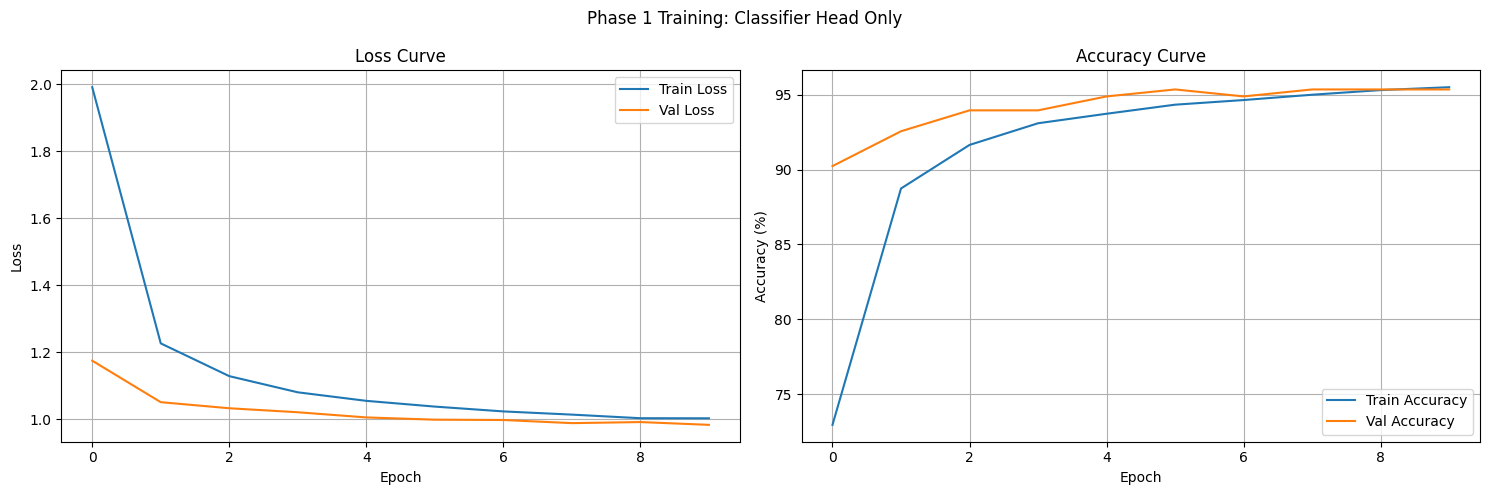

In [24]:
def plot_training_history(history, title="Training History"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss Curve')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracy
    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['val_acc'], label='Val Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Accuracy Curve')
    ax2.legend()
    ax2.grid(True)
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Plot Phase 1 training history
plot_training_history(history_phase1, "Phase 1 Training: Classifier Head Only")

## 8. Phase 2: Fine-tuning the Model

In this phase, we'll unfreeze more layers of the model and train with a lower learning rate. This fine-tuning process allows the pre-trained features to be adjusted to better suit our bird species dataset.

In [25]:
# Phase 2: Fine-tune the model
def train_phase2(model, train_loader, val_loader, num_epochs=NUM_EPOCHS_PHASE2):
    # Unfreeze layers for fine-tuning
    # For EfficientNet, we'll unfreeze the last set of blocks
    unfreeze_layers = []
    for name, param in model.named_parameters():
        if 'blocks.6' in name or 'blocks.5' in name or 'classifier' in name or 'fc' in name:
            param.requires_grad = True
            unfreeze_layers.append(name)
        else:
            param.requires_grad = False
    
    print(f"Unfreezing {len(unfreeze_layers)} parameters for fine-tuning")
    
    # Define optimizer and scheduler
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), 
                           lr=LEARNING_RATE_PHASE2, weight_decay=WEIGHT_DECAY)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)
    
    # Early stopping
    early_stopping = EarlyStopping(patience=7, mode='max')
    
    # Training loop
    best_val_acc = 0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print('-' * 10)
        
        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        # Validate
        val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%")
        
        # Update learning rate
        scheduler.step()
        print(f"Learning rate: {optimizer.param_groups[0]['lr']:.7f}")
        
        # Check if we should save the model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'../models/best_model_phase2_fold{CURRENT_FOLD}.pt')
            print(f"Saved best model with accuracy: {val_acc:.2f}%")
        
        # Check early stopping
        if early_stopping(val_acc) and early_stopping.early_stop:
            print("Early stopping triggered!")
            break
    
    # Load best model
    model.load_state_dict(torch.load(f'../models/best_model_phase2_fold{CURRENT_FOLD}.pt'))
    return model, history

# Train Phase 2
print("Starting Phase 2 Training: Fine-tuning")
model, history_phase2 = train_phase2(model, train_loader, val_loader)

Starting Phase 2 Training: Fine-tuning
Unfreezing 106 parameters for fine-tuning

Epoch 1/30
----------


Validation: 100%|██████████| 7/7 [00:00<00:00, 14.46it/s, loss=0.8586, acc=98.14%] 



Train Loss: 0.9340 Acc: 95.76%
Val Loss: 0.8586 Acc: 98.14%
Learning rate: 0.0001995
Saved best model with accuracy: 98.14%

Epoch 2/30
----------


Training: 100%|██████████| 212/212 [00:19<00:00, 10.90it/s, loss=0.8319, acc=98.72%]

Validation: 100%|██████████| 7/7 [00:00<00:00, 13.76it/s, loss=0.8161, acc=99.07%] 



Train Loss: 0.8319 Acc: 98.72%
Val Loss: 0.8161 Acc: 99.07%
Learning rate: 0.0001978
Saved best model with accuracy: 99.07%

Epoch 3/30
----------


Validation: 100%|██████████| 7/7 [00:00<00:00, 14.65it/s, loss=0.8089, acc=99.07%] 

Train Loss: 0.7911 Acc: 99.42%
Val Loss: 0.8089 Acc: 99.07%
Learning rate: 0.0001951

Epoch 4/30
----------



Validation: 100%|██████████| 7/7 [00:00<00:00, 15.09it/s, loss=0.7885, acc=98.60%] 

Train Loss: 0.7686 Acc: 99.63%
Val Loss: 0.7885 Acc: 98.60%
Learning rate: 0.0001914

Epoch 5/30
----------



Validation: 100%|██████████| 7/7 [00:00<00:00, 14.55it/s, loss=0.7884, acc=97.67%] 

Train Loss: 0.7547 Acc: 99.63%
Val Loss: 0.7884 Acc: 97.67%
Learning rate: 0.0001866

Epoch 6/30
----------



Validation: 100%|██████████| 7/7 [00:00<00:00, 14.71it/s, loss=0.7485, acc=99.53%] 



Train Loss: 0.7421 Acc: 99.81%
Val Loss: 0.7485 Acc: 99.53%
Learning rate: 0.0001809
Saved best model with accuracy: 99.53%

Epoch 7/30
----------


Training: 100%|██████████| 212/212 [00:18<00:00, 11.19it/s, loss=0.7332, acc=99.85%]

Validation: 100%|██████████| 7/7 [00:00<00:00, 14.61it/s, loss=0.7472, acc=99.53%] 

Train Loss: 0.7332 Acc: 99.85%
Val Loss: 0.7472 Acc: 99.53%
Learning rate: 0.0001743

Epoch 8/30
----------



Validation: 100%|██████████| 7/7 [00:00<00:00, 15.63it/s, loss=0.7576, acc=99.07%] 

Train Loss: 0.7288 Acc: 99.79%
Val Loss: 0.7576 Acc: 99.07%
Learning rate: 0.0001669

Epoch 9/30
----------



Training: 100%|██████████| 212/212 [00:19<00:00, 10.73it/s, loss=0.7225, acc=99.85%]

Validation: 100%|██████████| 7/7 [00:00<00:00, 15.18it/s, loss=0.7400, acc=99.07%] 

Train Loss: 0.7225 Acc: 99.85%
Val Loss: 0.7400 Acc: 99.07%
Learning rate: 0.0001588

Epoch 10/30
----------



Training: 100%|██████████| 212/212 [00:18<00:00, 11.18it/s, loss=0.7179, acc=99.93%]

Validation: 100%|██████████| 7/7 [00:00<00:00, 14.56it/s, loss=0.7395, acc=99.53%] 

Train Loss: 0.7179 Acc: 99.93%
Val Loss: 0.7395 Acc: 99.53%
Learning rate: 0.0001500

Epoch 11/30
----------



Validation: 100%|██████████| 7/7 [00:00<00:00, 14.40it/s, loss=0.7484, acc=99.07%] 

Train Loss: 0.7169 Acc: 99.87%
Val Loss: 0.7484 Acc: 99.07%
Learning rate: 0.0001407

Epoch 12/30
----------



Validation: 100%|██████████| 7/7 [00:00<00:00, 14.76it/s, loss=0.7415, acc=99.07%] 

Train Loss: 0.7129 Acc: 99.87%
Val Loss: 0.7415 Acc: 99.07%
Learning rate: 0.0001309

Epoch 13/30
----------



Training: 100%|██████████| 212/212 [00:20<00:00, 10.57it/s, loss=0.7101, acc=99.90%]

Validation: 100%|██████████| 7/7 [00:00<00:00, 15.69it/s, loss=0.7376, acc=98.60%] 

Train Loss: 0.7101 Acc: 99.90%
Val Loss: 0.7376 Acc: 98.60%
Learning rate: 0.0001208

Epoch 14/30
----------



Validation: 100%|██████████| 7/7 [00:00<00:00, 14.81it/s, loss=0.7399, acc=98.60%] 

Train Loss: 0.7091 Acc: 99.87%
Val Loss: 0.7399 Acc: 98.60%
Learning rate: 0.0001105

Epoch 15/30
----------



Training: 100%|██████████| 212/212 [00:18<00:00, 11.30it/s, loss=0.7054, acc=99.93%]

Validation: 100%|██████████| 7/7 [00:00<00:00, 15.36it/s, loss=0.7274, acc=99.53%] 

Train Loss: 0.7054 Acc: 99.93%
Val Loss: 0.7274 Acc: 99.53%
Learning rate: 0.0001000

Epoch 16/30
----------



Validation: 100%|██████████| 7/7 [00:00<00:00, 15.73it/s, loss=0.7285, acc=98.60%] 

Train Loss: 0.7036 Acc: 99.97%
Val Loss: 0.7285 Acc: 98.60%
Learning rate: 0.0000895

Epoch 17/30
----------



Validation: 100%|██████████| 7/7 [00:00<00:00, 15.16it/s, loss=0.7233, acc=99.07%] 

Train Loss: 0.7020 Acc: 99.94%
Val Loss: 0.7233 Acc: 99.07%
Learning rate: 0.0000792

Epoch 18/30
----------



Validation: 100%|██████████| 7/7 [00:00<00:00, 14.93it/s, loss=0.7238, acc=99.53%] 

Train Loss: 0.7017 Acc: 99.93%
Val Loss: 0.7238 Acc: 99.53%
Learning rate: 0.0000691

Epoch 19/30
----------



Training: 100%|██████████| 212/212 [00:20<00:00, 10.48it/s, loss=0.7000, acc=99.97%]

Validation: 100%|██████████| 7/7 [00:00<00:00, 13.60it/s, loss=0.7279, acc=99.07%] 

Train Loss: 0.7000 Acc: 99.97%
Val Loss: 0.7279 Acc: 99.07%
Learning rate: 0.0000593

Epoch 20/30
----------



Validation: 100%|██████████| 7/7 [00:00<00:00, 15.35it/s, loss=0.7279, acc=99.07%] 

Train Loss: 0.7008 Acc: 99.91%
Val Loss: 0.7279 Acc: 99.07%
Learning rate: 0.0000500

Epoch 21/30
----------



Validation: 100%|██████████| 7/7 [00:00<00:00, 14.80it/s, loss=0.7262, acc=99.07%] 

Train Loss: 0.6982 Acc: 100.00%
Val Loss: 0.7262 Acc: 99.07%
Learning rate: 0.0000412

Epoch 22/30
----------



Validation: 100%|██████████| 7/7 [00:00<00:00, 13.37it/s, loss=0.7162, acc=99.53%] 

Train Loss: 0.6980 Acc: 99.99%
Val Loss: 0.7162 Acc: 99.53%
Learning rate: 0.0000331

Epoch 23/30
----------



Validation: 100%|██████████| 7/7 [00:00<00:00, 13.92it/s, loss=0.7147, acc=99.53%] 

Train Loss: 0.6970 Acc: 100.00%
Val Loss: 0.7147 Acc: 99.53%
Learning rate: 0.0000257

Epoch 24/30
----------



Training: 100%|██████████| 212/212 [00:20<00:00, 10.25it/s, loss=0.6966, acc=100.00%]

Validation: 100%|██████████| 7/7 [00:00<00:00, 15.10it/s, loss=0.7146, acc=99.53%] 

Train Loss: 0.6966 Acc: 100.00%
Val Loss: 0.7146 Acc: 99.53%
Learning rate: 0.0000191

Epoch 25/30
----------



Validation: 100%|██████████| 7/7 [00:00<00:00, 15.14it/s, loss=0.7167, acc=99.53%] 

Train Loss: 0.6963 Acc: 99.99%
Val Loss: 0.7167 Acc: 99.53%
Learning rate: 0.0000134

Epoch 26/30
----------



Validation: 100%|██████████| 7/7 [00:00<00:00, 14.23it/s, loss=0.7166, acc=99.53%] 

Train Loss: 0.6963 Acc: 99.94%
Val Loss: 0.7166 Acc: 99.53%
Learning rate: 0.0000086

Epoch 27/30
----------



Training: 100%|██████████| 212/212 [00:19<00:00, 10.67it/s, loss=0.6958, acc=99.99%]

Validation: 100%|██████████| 7/7 [00:00<00:00, 14.13it/s, loss=0.7179, acc=99.53%] 

Train Loss: 0.6958 Acc: 99.99%
Val Loss: 0.7179 Acc: 99.53%
Learning rate: 0.0000049

Epoch 28/30
----------



Training: 100%|██████████| 212/212 [00:19<00:00, 10.95it/s, loss=0.6956, acc=100.00%]

Validation: 100%|██████████| 7/7 [00:00<00:00, 13.67it/s, loss=0.7148, acc=99.53%] 

Train Loss: 0.6956 Acc: 100.00%
Val Loss: 0.7148 Acc: 99.53%
Learning rate: 0.0000022

Epoch 29/30
----------



Validation: 100%|██████████| 7/7 [00:00<00:00, 15.00it/s, loss=0.7155, acc=99.53%] 

Train Loss: 0.6959 Acc: 99.97%
Val Loss: 0.7155 Acc: 99.53%
Learning rate: 0.0000005

Epoch 30/30
----------



Validation: 100%|██████████| 7/7 [00:00<00:00, 14.57it/s, loss=0.7160, acc=99.53%] 



Train Loss: 0.6965 Acc: 99.96%
Val Loss: 0.7160 Acc: 99.53%
Learning rate: 0.0000000


### Visualize Phase 2 Training Results

Let's plot the training and validation loss and accuracy to see how our model is performing during Phase 2.

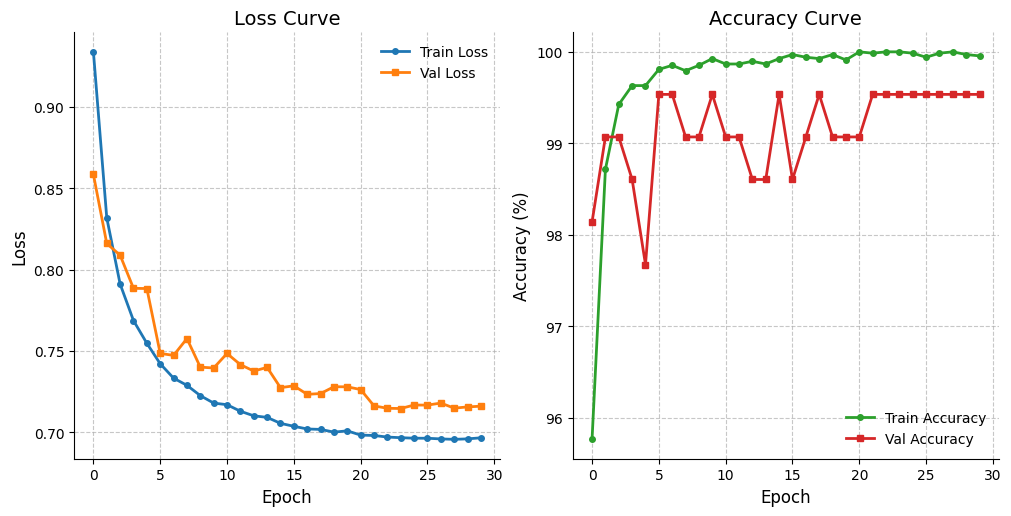

In [26]:
# Plot Phase 2 training history with improved formatting for publication
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

# Plot loss with improved colors
ax1.plot(history_phase2['train_loss'], color='#1f77b4', linewidth=2, marker='o', markersize=4, label='Train Loss')
ax1.plot(history_phase2['val_loss'], color='#ff7f0e', linewidth=2, marker='s', markersize=4, label='Val Loss')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss Curve', fontsize=14)
ax1.legend(frameon=False)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Plot accuracy with improved colors
ax2.plot(history_phase2['train_acc'], color='#2ca02c', linewidth=2, marker='o', markersize=4, label='Train Accuracy')
ax2.plot(history_phase2['val_acc'], color='#d62728', linewidth=2, marker='s', markersize=4, label='Val Accuracy')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Accuracy Curve', fontsize=14)
ax2.legend(frameon=False)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Make axes square
ax1.set_box_aspect(1)
ax2.set_box_aspect(1)

# Save figure to PDF without borders
plt.savefig('../results/phase2_training_history.pdf', format='pdf', bbox_inches='tight', 
            pad_inches=0, dpi=300, transparent=True)

plt.show()

## 9. Model Evaluation

Now we'll evaluate our model in detail, including:
- Confusion matrix
- Per-class accuracy
- Classification report

Evaluating final model...


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 12.95it/s]



Overall Accuracy: 100.00%
Class BAR-TAILED GODWIT: 100.00%
Class BARN OWL: 100.00%
Class BARN SWALLOW: 100.00%
Class BEARDED REEDLING: 100.00%
Class BLACK SWAN: 100.00%
Class BLACK-NECKED GREBE: 100.00%
Class COMMON FIRECREST: 100.00%
Class COMMON HOUSE MARTIN: 100.00%
Class COMMON STARLING: 100.00%
Class CROW: 100.00%
Class DUNLIN: 100.00%
Class EGYPTIAN GOOSE: 100.00%
Class EURASIAN BULLFINCH: 100.00%
Class EURASIAN GOLDEN ORIOLE: 100.00%
Class EURASIAN MAGPIE: 100.00%
Class EUROPEAN GOLDFINCH: 100.00%
Class EUROPEAN TURTLE DOVE: 100.00%
Class GRAY PARTRIDGE: 100.00%
Class GREY PLOVER: 100.00%
Class HAWFINCH: 100.00%
Class HOOPOES: 100.00%
Class HOUSE SPARROW: 100.00%
Class JACK SNIPE: 100.00%
Class LONG-EARED OWL: 100.00%
Class MALLARD DUCK: 100.00%
Class MANDRIN DUCK: 100.00%
Class MERLIN: 100.00%
Class NORTHERN FULMAR: 100.00%
Class NORTHERN GOSHAWK: 100.00%
Class NORTHERN SHOVELER: 100.00%
Class OSPREY: 100.00%
Class OYSTER CATCHER: 100.00%
Class PARUS MAJOR: 100.00%
Class PEREGR

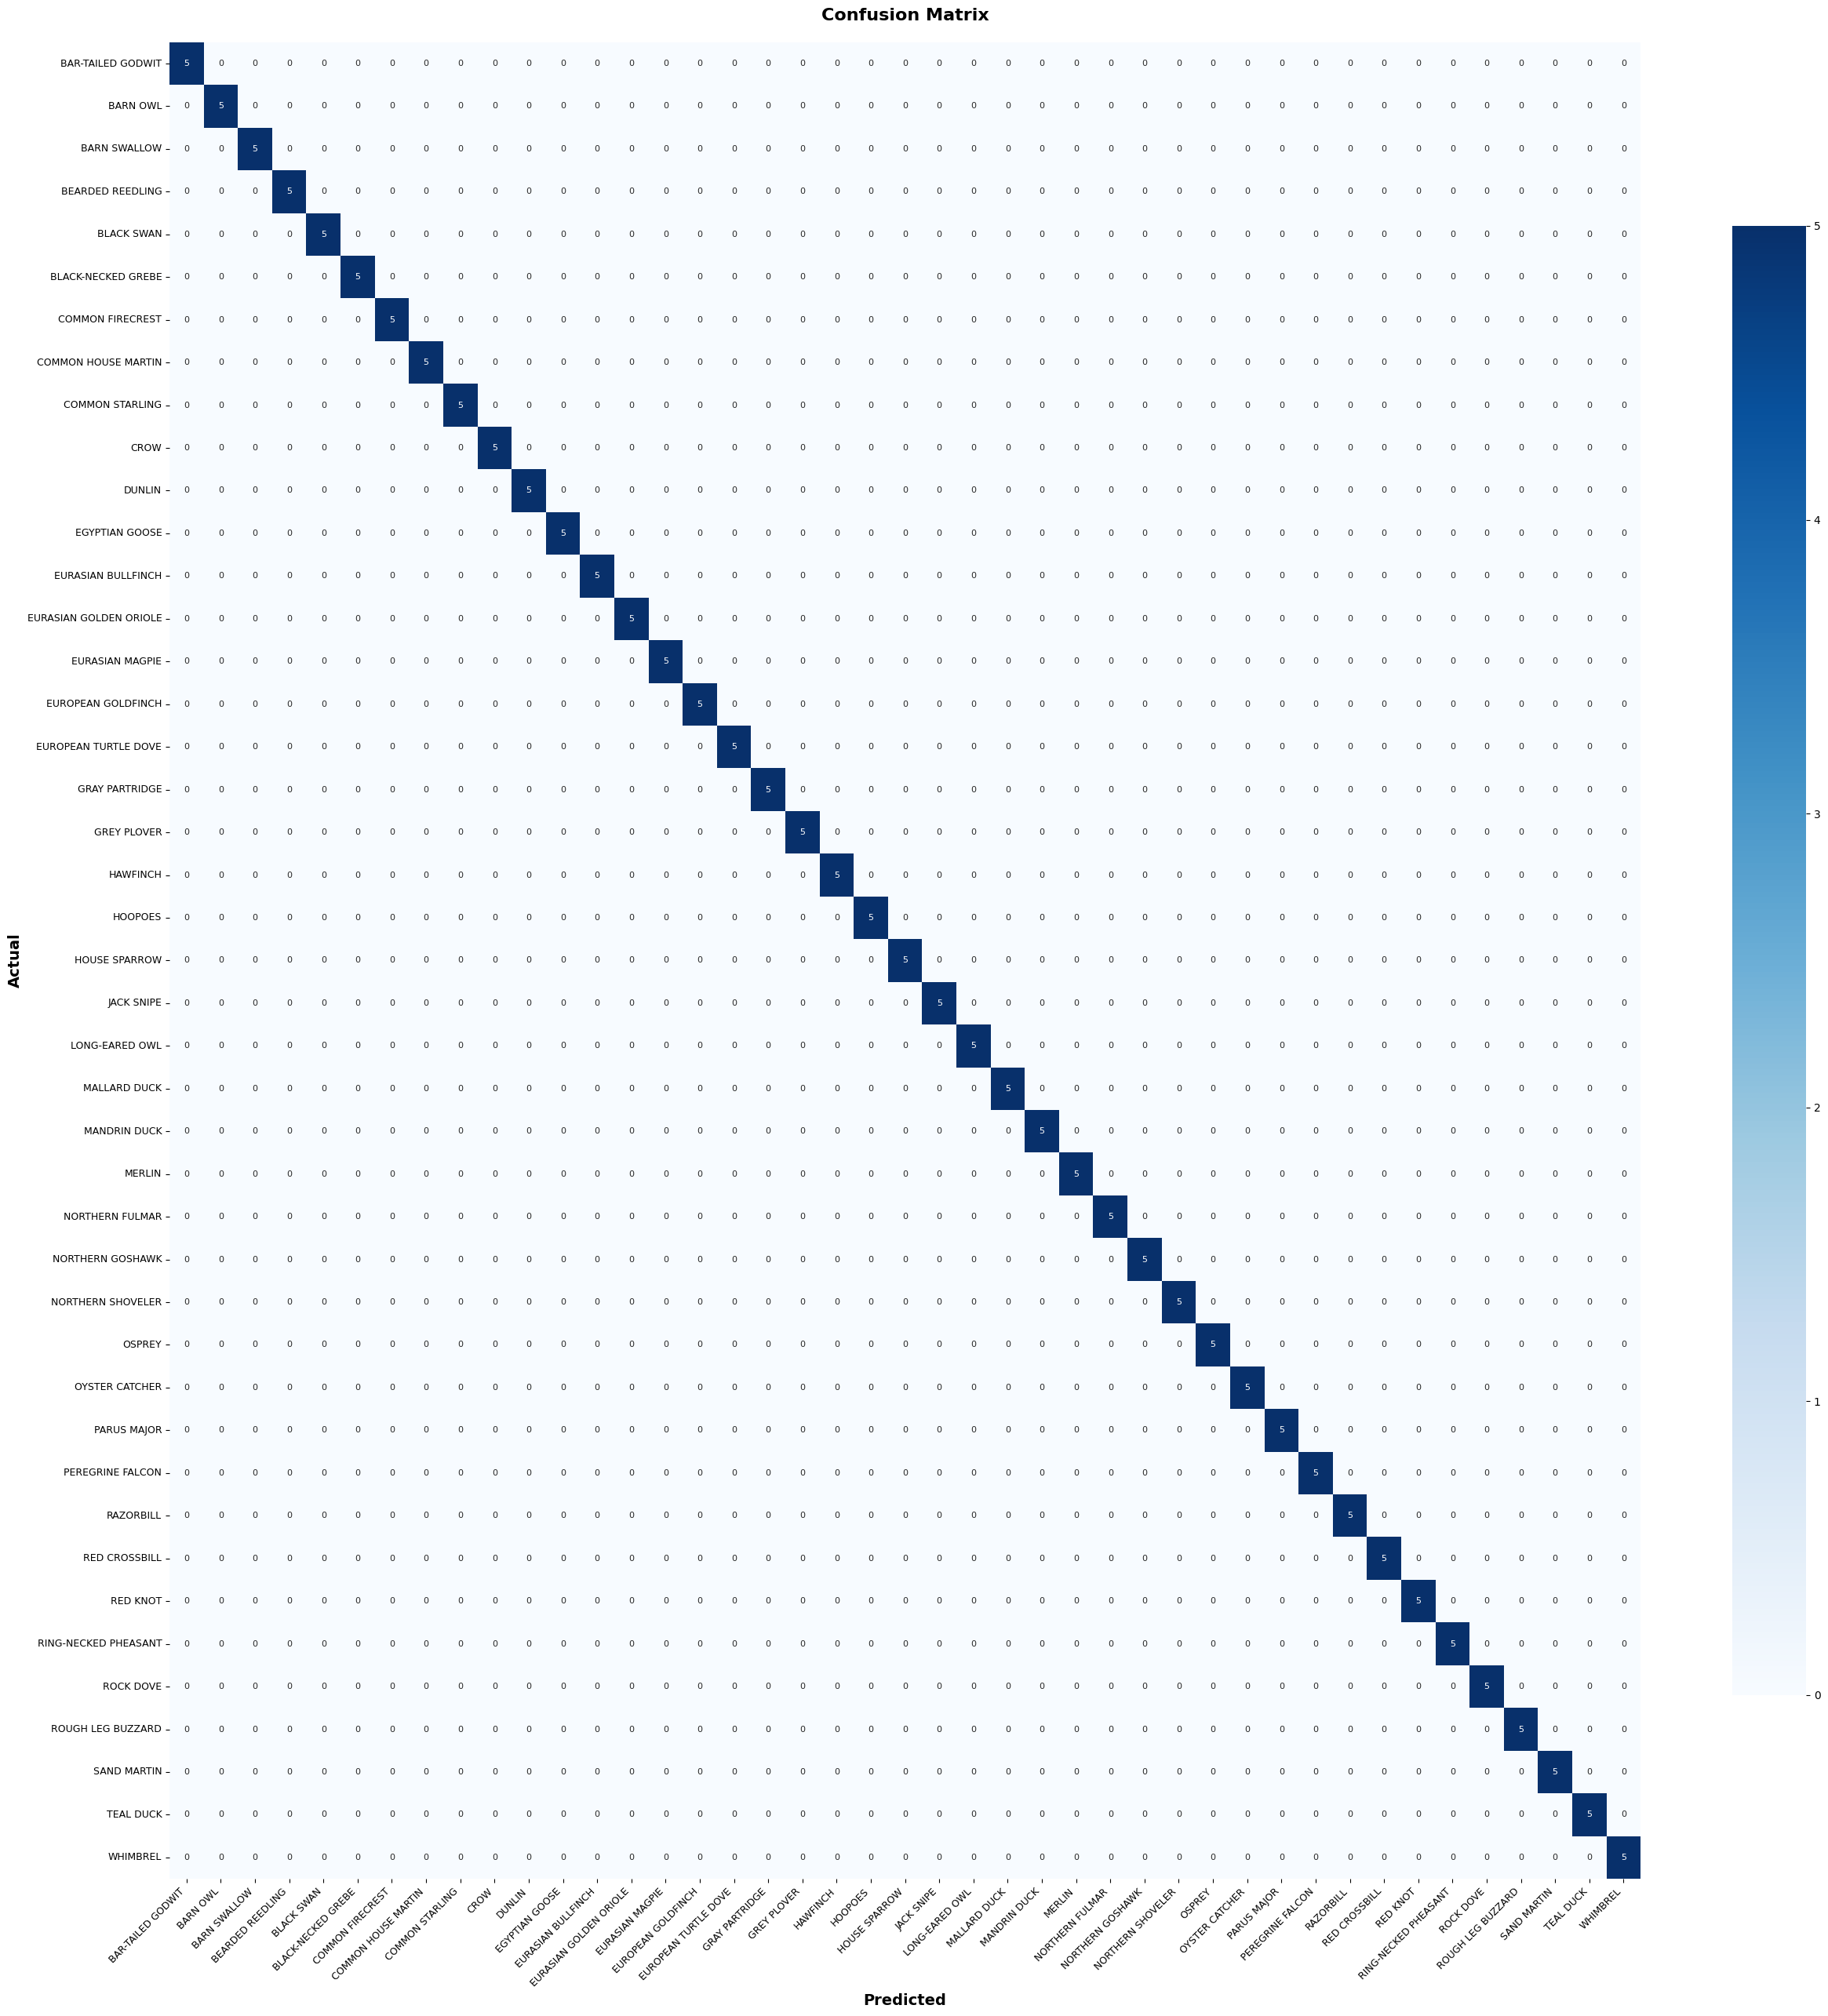

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(dataloader, desc="Evaluating"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    # Calculate accuracy
    accuracy = 100 * np.mean(np.array(all_preds) == np.array(all_targets))
    print(f"Overall Accuracy: {accuracy:.2f}%")
    
    # Create confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    
    # Per-class accuracy
    per_class_acc = cm.diagonal() / cm.sum(axis=1) * 100
    for i, acc in enumerate(per_class_acc):
        print(f"Class {class_names[i]}: {acc:.2f}%")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_targets, all_preds, target_names=class_names))
    
    return all_preds, all_targets, cm

# Use test set if available, otherwise use validation set
eval_loader = test_loader if test_loader else val_loader
print("Evaluating final model...")
all_preds, all_targets, cm = evaluate_model(model, eval_loader, device)

# Calculate dynamic figure size based on number of classes
fig_size = max(12, len(class_names) * 0.6)

# Plot confusion matrix with improved formatting for publication
plt.figure(figsize=(fig_size, fig_size))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'shrink': 0.8}, annot_kws={'size': 8})
plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)

# Improve text formatting to prevent overlapping
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, ha='right', fontsize=9)

# Remove spines for cleaner look
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save confusion matrix to PDF without borders
plt.savefig('../results/confusion_matrix.pdf', format='pdf', bbox_inches='tight', 
            pad_inches=0.1, dpi=300, transparent=True)

plt.show()

## 10. Test-Time Augmentation (TTA)

Test-time augmentation is a technique where we apply multiple augmentations to a test image and average the predictions. This can lead to more robust predictions, especially for challenging images.


Sample 1:
True class: EURASIAN MAGPIE
Regular prediction: EURASIAN MAGPIE (confidence: 0.8940)
TTA prediction: EURASIAN MAGPIE (confidence: 0.9081)


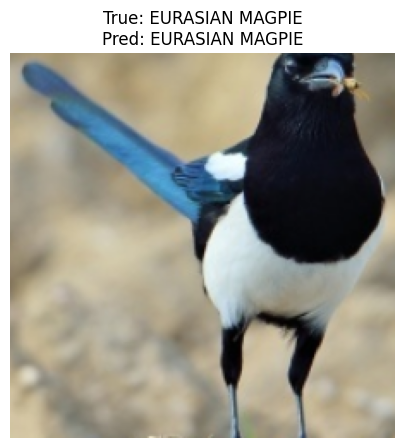


Sample 2:
True class: EURASIAN BULLFINCH
Regular prediction: EURASIAN BULLFINCH (confidence: 0.8897)
TTA prediction: EURASIAN BULLFINCH (confidence: 0.9071)


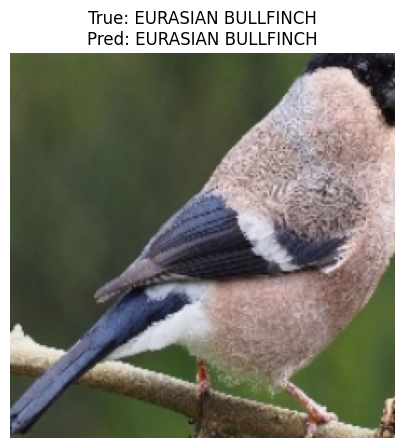


Sample 3:
True class: EGYPTIAN GOOSE
Regular prediction: EGYPTIAN GOOSE (confidence: 0.9069)
TTA prediction: EGYPTIAN GOOSE (confidence: 0.9314)


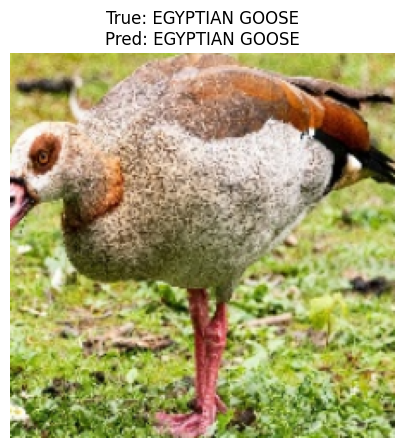


Sample 4:
True class: COMMON HOUSE MARTIN
Regular prediction: COMMON HOUSE MARTIN (confidence: 0.8691)
TTA prediction: COMMON HOUSE MARTIN (confidence: 0.8122)


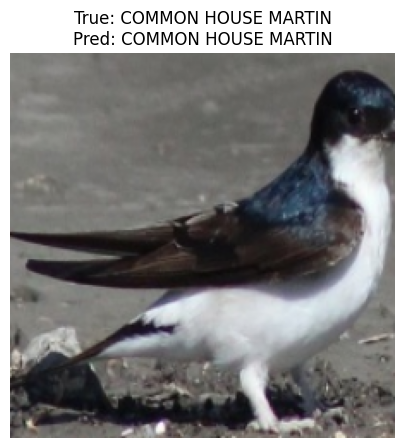


Sample 5:
True class: RING-NECKED PHEASANT
Regular prediction: RING-NECKED PHEASANT (confidence: 0.9436)
TTA prediction: RING-NECKED PHEASANT (confidence: 0.9342)


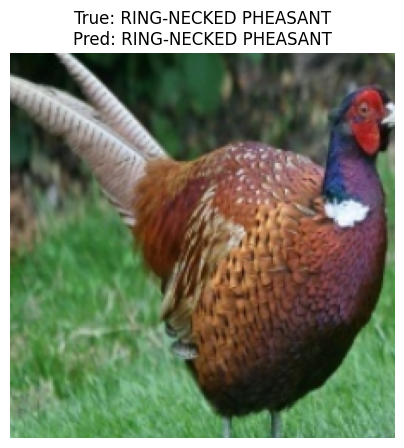

In [28]:
def test_time_augmentation(model, image_tensor, device, num_augmentations=10):
    """Apply multiple augmentations to a single image and average predictions"""
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(device)  # Add batch dimension
    
    # Original prediction
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)
    
    # Horizontal flip
    flipped = torch.flip(image_tensor, [3])  # Flip along width dimension
    with torch.no_grad():
        flip_outputs = model(flipped)
        flip_probabilities = torch.softmax(flip_outputs, dim=1)
    
    # Average the predictions
    avg_probabilities = (probabilities + flip_probabilities) / 2
    
    # Get top prediction
    _, predicted_class = torch.max(avg_probabilities, 1)
    
    return predicted_class.item(), avg_probabilities.cpu().numpy()[0]

# Test TTA on a few random samples
def test_tta_on_samples(model, dataloader, device, num_samples=5):
    model.eval()
    # Get random samples
    images, labels = [], []
    for _ in range(num_samples):
        idx = random.randint(0, len(dataloader.dataset) - 1)
        img, label = dataloader.dataset[idx]
        images.append(img)
        labels.append(label)
    
    for i, (image, true_label) in enumerate(zip(images, labels)):
        # Regular prediction
        image_tensor = image.unsqueeze(0).to(device)
        with torch.no_grad():
            outputs = model(image_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted_class = torch.max(probabilities, 1)
        
        # TTA prediction
        tta_class, tta_probs = test_time_augmentation(model, image, device)
        
        # Display results
        print(f"\nSample {i+1}:")
        print(f"True class: {class_names[true_label]}")
        print(f"Regular prediction: {class_names[predicted_class.item()]} "
              f"(confidence: {probabilities[0][predicted_class].item():.4f})")
        print(f"TTA prediction: {class_names[tta_class]} "
              f"(confidence: {tta_probs[tta_class]:.4f})")
        
        # Display image
        img_display = image.numpy().transpose(1, 2, 0)
        img_display = img_display * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)
        img_display = np.clip(img_display, 0, 1)
        
        plt.figure(figsize=(5, 5))
        plt.imshow(img_display)
        plt.title(f"True: {class_names[true_label]}\nPred: {class_names[tta_class]}")
        plt.axis('off')
        plt.show()

# Test TTA on some random samples
test_tta_on_samples(model, eval_loader, device, num_samples=5)

## 11. K-Fold Cross-Validation (Optional)

If we want to maximize our model performance, we can train the model on all K folds and ensemble the predictions. This section demonstrates how to implement k-fold cross-validation for training and model ensembling.

In [29]:
def train_kfold_models(k_folds=K_FOLDS, train_dataset=train_dataset):
    """Train models on multiple folds and save them"""
    models = []
    
    for fold in range(k_folds):
        print(f"\n{'='*20}\nTraining Fold {fold+1}/{k_folds}\n{'='*20}")
        
        # Get data loaders for this fold
        train_loader, val_loader, _, _ = get_data_loaders(
            train_dataset, k_fold=k_folds, fold_index=fold
        )
        
        # Create and train model
        model = create_model(NUM_CLASSES).to(device)
        
        # Phase 1: Train classifier head
        print("Phase 1: Training classifier head...")
        model, _ = train_phase1(model, train_loader, val_loader, num_epochs=NUM_EPOCHS_PHASE1)
        
        # Phase 2: Fine-tune
        print("Phase 2: Fine-tuning...")
        model, _ = train_phase2(model, train_loader, val_loader, num_epochs=NUM_EPOCHS_PHASE2)
        
        # Save final model
        torch.save(model.state_dict(), f'final_model_fold{fold}.pt')
        models.append(model)
        
    return models

def ensemble_prediction(models, image_tensor, device):
    """Ensemble predictions from multiple models"""
    image_tensor = image_tensor.unsqueeze(0).to(device)
    
    all_probabilities = []
    for model in models:
        model.eval()
        with torch.no_grad():
            outputs = model(image_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            all_probabilities.append(probabilities)
    
    # Average probabilities
    avg_probabilities = torch.mean(torch.stack(all_probabilities), dim=0)
    _, predicted_class = torch.max(avg_probabilities, 1)
    
    return predicted_class.item(), avg_probabilities.cpu().numpy()[0]

# Note: Uncomment the following code to train models on all folds
# This can take a long time to run!

# print("Starting k-fold cross-validation training...")
# fold_models = train_kfold_models(k_folds=K_FOLDS)
# print("Completed training all folds!")

# # Test ensemble prediction on a random image
# idx = random.randint(0, len(eval_loader.dataset) - 1)
# img, label = eval_loader.dataset[idx]
# 
# ensemble_class, ensemble_probs = ensemble_prediction(fold_models, img, device)
# print(f"\nEnsemble Prediction Test:")
# print(f"True class: {class_names[label]}")
# print(f"Ensemble prediction: {class_names[ensemble_class]}")
# print(f"Top probabilities: {sorted(zip(class_names, ensemble_probs), key=lambda x: x[1], reverse=True)[:3]}")

## 12. Model Export and Inference Demo

Finally, let's export our best model and demonstrate how to use it for inference on new images.

Model exported to ../models/bird_species_classifier.pt


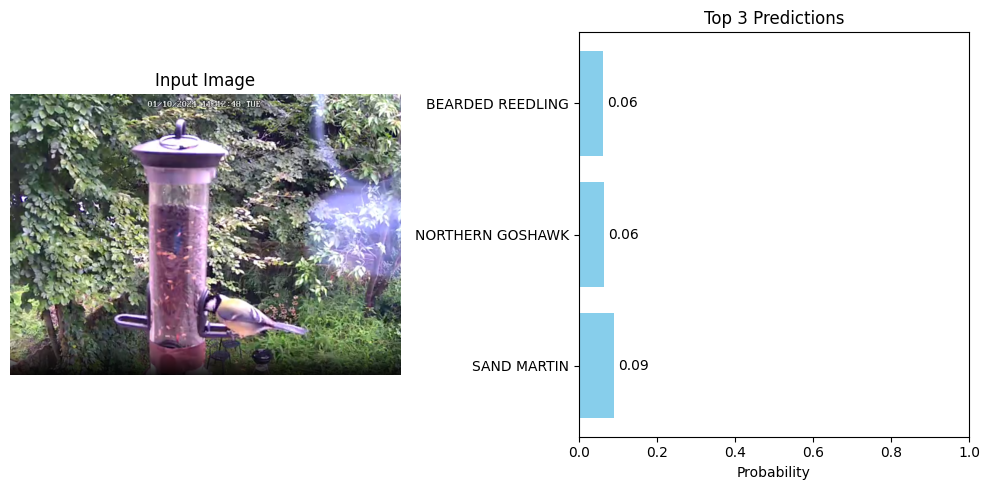

Predicted bird species: SAND MARTIN with confidence 0.09


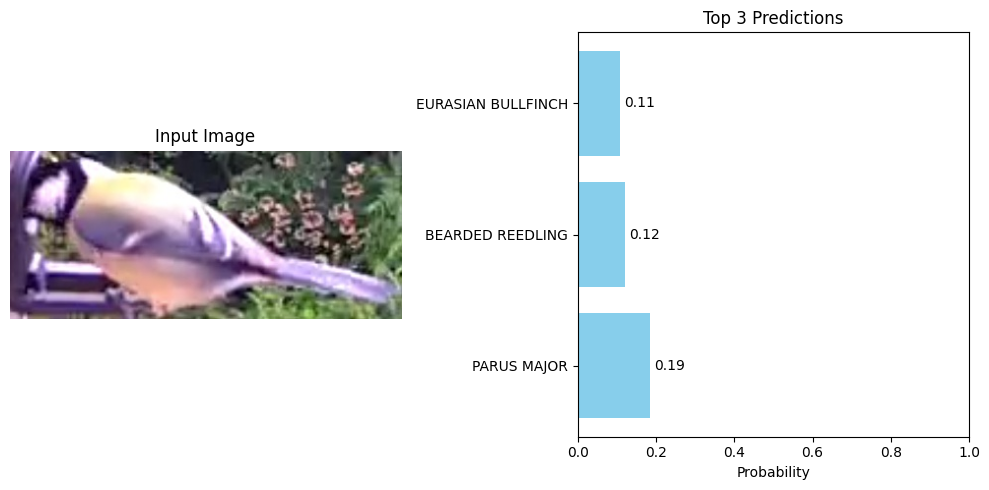

Predicted bird species: PARUS MAJOR with confidence 0.19


In [30]:
# Save model architecture and weights in a format that can be easily loaded
def export_model(model, filename='../models/bird_species_classifier.pt'):
    # Save model info
    model_info = {
        'state_dict': model.state_dict(),
        'class_names': class_names,
        'model_name': 'efficientnet_b3',
        'img_size': IMG_SIZE,
        'mean': IMAGENET_MEAN,
        'std': IMAGENET_STD
    }
    torch.save(model_info, filename)
    print(f"Model exported to {filename}")

# Export the trained model
export_model(model)

# Function to load model and make predictions
def load_model_and_predict(image_path, model_path='../models/bird_species_classifier.pt'):
    # Load model info
    model_info = torch.load(model_path, map_location=device)
    
    # Create model
    model = create_model(len(model_info['class_names']), model_name=model_info['model_name'])
    model.load_state_dict(model_info['state_dict'])
    model = model.to(device)
    model.eval()
    
    # Load and preprocess image
    img = Image.open(image_path).convert('RGB')
    transform = A.Compose([
        A.Resize(model_info['img_size'], model_info['img_size']),
        A.Normalize(mean=model_info['mean'], std=model_info['std']),
        ToTensorV2(),
    ])
    img_tensor = transform(image=np.array(img))['image']
    
    # Apply TTA for better prediction
    class_idx, probs = test_time_augmentation(model, img_tensor, device)
    
    # Get top 3 predictions
    top_indices = np.argsort(probs)[-3:][::-1]
    top_classes = [model_info['class_names'][i] for i in top_indices]
    top_probs = [probs[i] for i in top_indices]
    
    # Display results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Input Image")
    
    plt.subplot(1, 2, 2)
    bars = plt.barh([1, 2, 3], top_probs, color='skyblue')
    plt.yticks([1, 2, 3], top_classes)
    plt.xlabel("Probability")
    plt.xlim(0, 1)
    plt.title("Top 3 Predictions")
    
    for i, bar in enumerate(bars):
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                 f"{top_probs[i]:.2f}", va='center')
    
    plt.tight_layout()
    plt.show()
    
    return top_classes[0], top_probs[0]

# Example of prediction (uncomment to use on a specific image)
# Replace 'path_to_test_image.jpg' with the path to your test image
predicted_class, confidence = load_model_and_predict('../data/test_bird.png')
print(f"Predicted bird species: {predicted_class} with confidence {confidence:.2f}")
predicted_class, confidence = load_model_and_predict('../data/test_bird_cropped.jpg')
print(f"Predicted bird species: {predicted_class} with confidence {confidence:.2f}")

## 13. Conclusion

In this notebook, we've built a high-accuracy bird species classifier using:

1. A custom dataset with strong data augmentation
2. Transfer learning with EfficientNet-B3 pre-trained on ImageNet
3. Two-phase training (classifier head followed by fine-tuning)
4. Techniques like label smoothing, early stopping, and learning rate scheduling
5. Test-time augmentation for better prediction accuracy

To further improve the model, consider:
- Experimenting with different pre-trained models
- Trying more augmentation techniques
- Using K-fold cross-validation and model ensembling
- Collecting more training data if possible